<a href="https://colab.research.google.com/github/premonish/YOUNGER/blob/main/YOUNGER_Age_Estimator_WRANGLING_EDA_%5BIn_Progress%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOUNGER - Age Estimator**

# **I. PROBLEM IDENTIFICATION**

## A. Introduction

**CONTEXT:** "Babyface" a startup skincare company wants to build an app that can estimate a person’s age from an image. They need an app to create an age estimate within about 5 years of their real age. The primary problem to solve is: When given a photo of a face, estimate the age with reasonable accuracy. Babyface will eventually use this to create "before & after" age estimates to demonstrate the benefits of their skin products.

**[INPUT] → [OUTPUT]**

**[Photo of a face] → [Age estimate]**

## B. Proposed Method

**i. The techniques** to explore are a combination of **Support Vector Machines, Decision Trees, K Nearest Neighbor, and CNN** (for feature detection).

**ii. Pipeline**

1. DATA WRANGLING - Source Data, Download Data, Explore Data, Clean Data
2. EXPLORATORY DATA ANALYSIS - Statistical EDA, Visual EDA
3. PREPROCESSING - Face Detection, Crop Images, Augmentation
4. TRAINING - Feature Extraction
5. MODELING - Prediction, Hyperparameter Tuning

# **II. DATA WRANGLING**

**DATASET:** Researchers from ETH Zurich University have created a labeled dataset with success in predicting age and gender from face images.
An image dataset consists of human faces with ages. There are 99 folders where the name of each folder represents the age of the faces inside the folder.

"In total we obtained 460,723 face images from 20,284 celebrities from IMDb and 62,328 from Wikipedia, thus 523,051 in total."

[IMDB-WIKI – 500k+ face images with age and gender labels
Rasmus Rothe, Radu Timofte, Luc Van Gool](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)


**DETAILS:** The dataset that we will use for our age predictor was created by Rasmus Rothe, Radu Timofte, Luc Van Gool in combination with a competition "ChaLearn LAP 2015" dataset. This dataset was scraped from IMDb and Wikipedia. The dataset is labeled with date-of-birth (DOB) and gender and includes only images with timestamps, indicating when the image was captured. The age of the person in the image can be obtained by simply subtracting the person's date of birth from the timestamp date. It is important to note that some of the IMDb dataset images are "production photos" like movie posters and the timestamps may not be precise, since movie production cycles can be months long.

**APPROACH:** *Download, Explore, Clean:* We will start by downloading the dataset and exploring the images and metadata to understand how to label the data properly with the ages of the subjects. The ages can be calculated from the subjects' date of birth and the date the related photo was taken. We will then clean our dataset as needed.

In [ ]:
# !pip install tensorflow

**Why Google Colab?**

Google Colab was chosen as we intend to use a deep learning convolutional neural network (CNN). Google Colab provides free access to GPUs which will expedite training immensely. The platform is also very handy for team collaboration in a Google Docs/Sheets style. 

In [ ]:
# Creating a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt

In [ ]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
import requests
import scipy.io
import random
from datetime import datetime, date, time, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input

In [ ]:
# mount GDrive where the dataset is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### VIEW A RANDOM IMAGE FROM DATASET ###
# loc = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/wiki_crop_subset/81800_1986-06-13_2011.jpg'
directory = '/content/drive/MyDrive/YOUNGER/wiki_crop/00'
dir_list = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        dir_list.append(os.path.join(directory, filename))

rando = random.randint(0,len(dir_list))
image1 = Image.open(dir_list[rando])
image1

**Metadata Inspection** 

We will first take a look at the metadata before looking at the image dataset. 

In [ ]:
### LOAD METADATA FILE ###
# wiki_mat_path = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/WIKI_CROP/wiki.mat'
wiki_mat_path = '/content/drive/MyDrive/YOUNGER/wiki.mat' # COLAB

# load .mat as python dict
mat = scipy.io.loadmat(wiki_mat_path)

In [ ]:
# Metadata Keys #
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'wiki'])


**Metadata Features**

The metadata is in a MATLAB ".mat" format and has a nested structure. We will dig into the layers of the file to explore out the data. There are some features that have been created from preprocessing the dataset. These preprocessed features are: face_location, face_score, and second_face_score. The features were created with a face detection algorithm ([Mathias et al. 2014](https://https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles)) and contain the relative position of the face, how strongly a face was detected in the image and how strongly a second face was detected, respectively. 

In [ ]:
### INSPECT METADATA STRUCTURE ###
print(mat['wiki'][0][0])

(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
        array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
        array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
        array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
        array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
        array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
      dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
        array(['Dettmar Cramer'], dtype='<U14'),
        array(['Marc Okrand'], dtype='<U11'), ...,
        array(['Michael Wiesinger'], dtype='<U17'),
        array(['Johann Grugger'], dtype='<U14'),
        array(['Greta Van Susteren'], dtype='<U18')]], dtype=object), array([[array([[111.29109473, 111.29109473, 252.66993082, 252.66993082]]),
  

**MATLAB to pandas DataFrame**

Next, we will transform the data from the '.mat' MATLAB nested format into an easier-to-read pandas DataFrame with a familiar table structure.

In [ ]:
### CREATE DATAFRAME FROM METADATA ###

# Assign the length of the array to 'num_of_observations'
num_of_observations = mat['wiki'][0][0][0].shape[1]
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create pandas dataframe as tall as 'num_of_observations' with column headers from metadata
df = pd.DataFrame(index = range(0, num_of_observations), columns = columns)

# Iterate through the 'wiki' header of the metadata
for i in mat:
  if i == "wiki":
    wiki_array = mat[i][0][0]       # Dig two layers into the dict structure and assign to 'wiki_array'
    for b in range(len(wiki_array)):        # Create a pandas DataFrame for each nested value and assign to respective df[columns]
      df[columns[b]] = pd.DataFrame(wiki_array[b][0])

df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


**Metadata Feature Descriptions**

---

**dob:** date of birth (Matlab serial date number)

**photo_taken:** year when the photo was taken

**full_path:** path to image file in folder

**gender:** 0 = female, 1 = male, NaN = unknown

**name:** full name 

***face_location:** location of the face 

***face_score:** detector score ('inf'= no face detected)

***second_face_score:** detector score of the face with the second highest score. 'NaN' if no second face was detected.

---

(*)  Features created during preprocessing indicated with asterisk *

In [ ]:
### INSPECT DATAFRAME ###
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB
None


(62328, 8)

**Observations**

1. 'gender' column has missing values. 
2. 'second_face_score' has spare data and mostly Null values. 

We need to deal with these.

In [ ]:
print("General information about the dataset: ")
print("======================================")
print("Oldest Photo Date: "+str(df.photo_taken.min()))
print("Most Recent Photo Date: "+str(df.photo_taken.max()))
print("Minimum Face Score: "+str(df.face_score.min()))
print("Maximum Face Score: "+str(round(df.face_score.max(),3)))
print("Null Second Face Scores: "+ str(df.second_face_score.isna().sum()))

General information about the dataset: 
Oldest Photo Date: 1940
Most Recent Photo Date: 2015
Minimum Face Score: -inf
Maximum Face Score: 7.081
Null Second Face Scores: 58232


In [ ]:
# Function to convert Matlab datenum into Python datetime
def datenum_to_datetime(datenum):
  days = datenum % 1
  hours = days % 1 * 24
  minutes = hours % 1 * 60
  seconds = minutes % 1 * 60
  exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
  return exact_date.year
 
# Convert Matlab datenum into Python datetime & create a new columns 'date_of_birth'
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

# Compute age by subtracting 'date_of_birth' from 'photo_taken'
df['age'] = df['photo_taken'] - df['date_of_birth']
df['age'][:5]

0    28
1    39
2    60
3    31
4    41
Name: age, dtype: int64

In [ ]:
# Check the maximum & minimum age...
print('age.max', str(df.age.max()))
print('age.min', str(df.age.min()))

age.max 1996
age.min -74


In [ ]:
# odd results...require cleaning
# Remove ages over 100 & remove ages under 0
df = df[df['age'] <= 100]
df = df[df['age'] > 0]

In [ ]:
### CLEAN THE DATASET ###
# Remove images where faces are not detected
df = df[df['face_score'] != -np.inf]
 
# Include only images with a second face score missing (NaN)
# We don't want to deal with extra faces in the images
df = df[df['second_face_score'].isna()]
 
# Include images that have a primary 'face_score' of 3 or more
df = df[df['face_score'] >= 3]

# Remove records with missing gender data
df = df[~df['gender'].isna()]

**Columns to Drop**

'name' are arbitrary, so we will drop the names.

'dob' has been replaced by date_of_birth.

'second_face_score' are all "Nan". Let's drop it.

In [ ]:
# Drop columns that won't inform the prediction model
df = df.drop(columns = ['dob','name', 'second_face_score'])

# **III. EXPLORATORY DATA ANALYSIS**

**Distribution Visualizations**

Let's take a look at the shape of the dataset's variables with some colorful histograms.

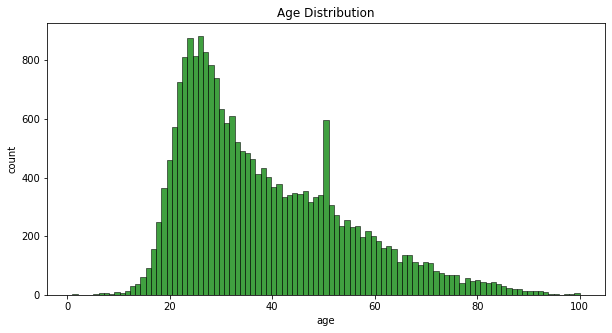

In [ ]:
# Plot Age Distribution represented in the dataset
plt.figure(figsize=(10, 5))
# histogram_age = df['age'].hist(bins=df['age'].nunique())
sns.histplot(df['age'], bins=df['age'].nunique(), color='green')
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

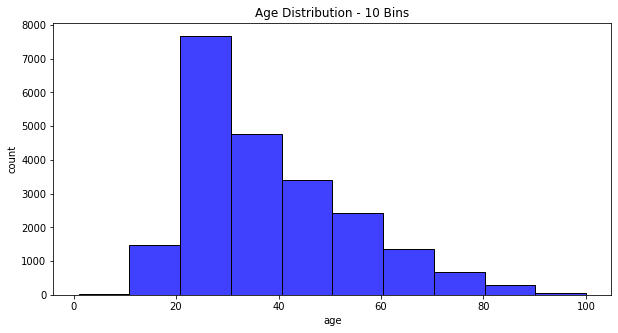

In [ ]:
# Plot Age Distribution in ten (10) age bins
plt.figure(figsize=(10, 5))
# histogram_age = df['age'].hist(bins=10)
sns.histplot(df['age'],bins=10, color='blue')
plt.title('Age Distribution - 10 Bins')
plt.xlabel('age')
plt.ylabel('count');

The Age Distribution is right skewed with a large representation in the 20-30 age range. We will consider balancing the classes before training our algorithm as a biased dataset would lead to a biased output (age estimation). 

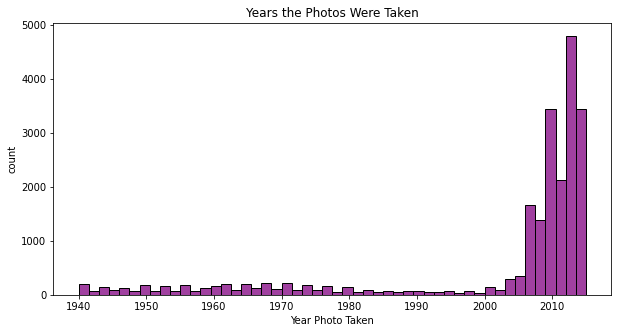

In [ ]:
# Plot Years Photos Taken Distribution represented in the dataset
plt.figure(figsize=(10, 5))
sns.histplot(df['photo_taken'], bins=50, color='purple')
# histogram_age = df['face_score'].hist(bins=50)
plt.title('Years the Photos Were Taken')
plt.xlabel('Year Photo Taken')
plt.ylabel('count');

As we might expect, most of the images in the dataset were created in the last 20 years, coinciding with the boom of digital imagery and the explosion of digital data creation.

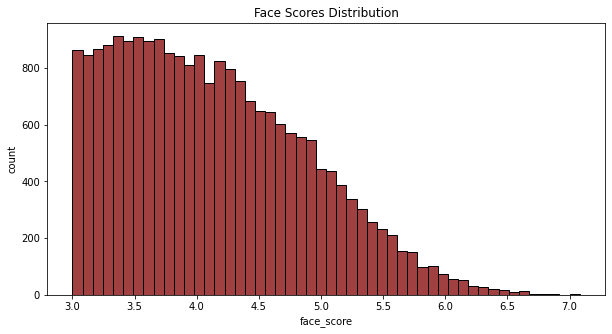

In [ ]:
# Plot face_score Distribution represented in the dataset
plt.figure(figsize=(10, 5))
sns.histplot(df['face_score'], bins=50, color='maroon')
# histogram_age = df['face_score'].hist(bins=50)
plt.title('Face Scores Distribution')
plt.xlabel('face_score')
plt.ylabel('count');

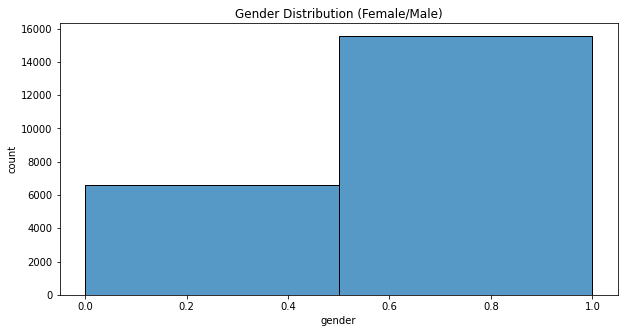

In [ ]:
# Plot Gender Distribution represented in the dataset
plt.figure(figsize=(10, 5))
sns.histplot(df['gender'], bins=2)
# histogram_age = df['gender'].hist(bins=2)
plt.title('Gender Distribution (Female/Male)')
plt.xlabel('gender')
plt.ylabel('count');

The gender distribution is very uneven with many more 'male' subjects represented. We will consider balancing this as well.

In [ ]:
# METADATA Dataframe Info #
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22138 entries, 0 to 62327
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   photo_taken    22138 non-null  uint16 
 1   full_path      22138 non-null  object 
 2   gender         22138 non-null  float64
 3   face_location  22138 non-null  object 
 4   face_score     22138 non-null  float64
 5   date_of_birth  22138 non-null  int64  
 6   age            22138 non-null  int64  
dtypes: float64(2), int64(2), object(2), uint16(1)
memory usage: 1.2+ MB


In [ ]:
### descirptive statistics on the Age Distribution ###
df.age.describe()

count    22138.000000
mean        38.210678
std         15.871291
min          1.000000
25%         26.000000
50%         34.000000
75%         48.000000
max        100.000000
Name: age, dtype: float64

Let's move on to explore the image dataset directly.

##**Images ---> PIXEL values ---> Vectors**

We need to convert the images from pixels to vectors to prepare our images to hunt for patterns (features).

Each digital image is composed of a large grid of pixels. In color images, each pixel has 3 color channels: Red, Green, Blue (RGB). Each color channel's intensity are in the range [0-255]. 

To translate our images from photos (jpg format) to vectors of pixel values, we will first use a *Keras module called "load_img" to read the images in a PIL (Python Imaging Library) format. We will set the 'color mode' argument to (RGB) and set the target-size to 224 x 224 pixels. Next, we will use Kera's "img_to_array" module to extract the pixel information and store it in an array (index-based vector) of 150,528 numbers per image (224x224x3). 

*Keras is a high-level API interface for TensorFlow for working with artificial neural networks (ANN). TensorFlow & Keras are frequently used on computer vision image classification projects, such as this. 

*Prem: I remember being inspired to learn more about AI when hearing VC Marc Andreessen talk about how acccessible TensorFlow was in a 2018 [Tim Ferriss Show podcast](https://https://tim.blog/2018/01/01/the-tim-ferriss-show-transcripts-marc-andreessen/). He said "So all of a sudden, AI is like a tractable thing that you can just have on your own laptop, and you can build new things on top of it."*

In [ ]:
# Create function to load images using 'load_img' and create 1 array per image (224,224,3)
target_size=(224, 224)

def getImagePixels(image_path):
    # img = image.load_img("C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/wiki_crop/%s" % image_path[0], grayscale=False, target_size=(224, 224))
    img = image.load_img("/content/drive/MyDrive/YOUNGER/wiki_crop/%s" % image_path[0], color_mode='rgb', target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    # x = preprocess_input(x)
    return x

In [ ]:
### SUBSETTING THE DATASET FOR RAPID TESTING ### ### TESTING ### ### TESTING ### ### TESTING ###
df = df[:4000]
### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### 

In [ ]:
%%time
# apply 'getImagePixels' function to all observations and create new column df.pixels
df['pixels'] = df['full_path'].apply(getImagePixels)

CPU times: user 16 s, sys: 3.13 s, total: 19.1 s
Wall time: 44min 56s


#***Technical Issue: Long Runtime**

^ Running the cell above can take very long time. For example, the cell took 44min 56s when I ran it over a dataset of 4000 observations. I'd like to figure out how to make the process more efficient. I'm going to try a couple different ideas.

##*Any ideas would be greatly appreciated.*

##**"Average Face" Image**

It is interesting to think about the concept of an average face. What would that look like? Well, since we already have our face image dataset, we can aggregate the mean (average) of the arrays of each image and create "average face" images with different subset sizes. Let's try this with 2, 5, 20, 100, and 1000 face images for fun.

*Aside*: The National Geographic [created an image](https://https://www.cbsnews.com/news/meeting-earths-most-typical-person/) from 190,000 overlayed images to create an 'everyman' concept image. 

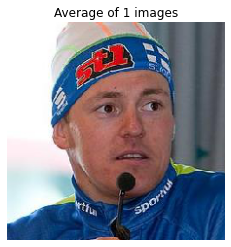

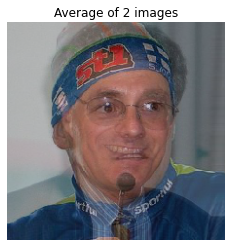

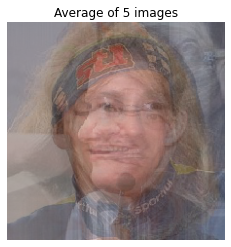

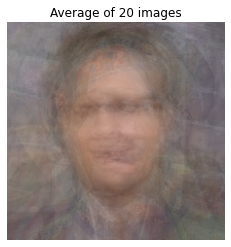

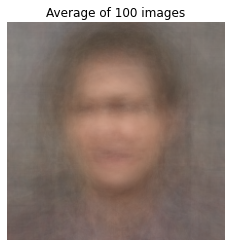

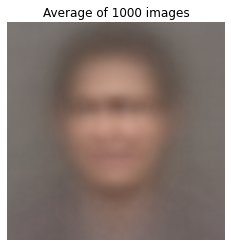

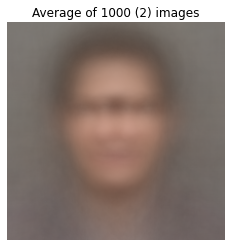

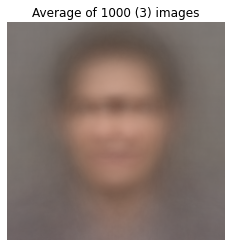

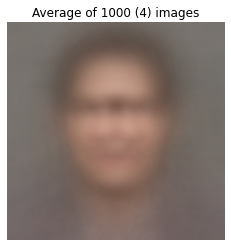

In [ ]:
def find_mean_img(full_mat, title, size=(224,224,3)):
    mean_img = np.mean(full_mat, axis=0)
    mean_img = mean_img.reshape(size)
    mean_img = mean_img/255
    plt.imshow(mean_img)
    plt.title(f'Average of {title} images')
    plt.axis('off')
    plt.show()
    return mean_img

all_mean = find_mean_img(df['pixels'][0:1], '1')
all_mean2 = find_mean_img(df['pixels'][:2], '2')
all_mean5 = find_mean_img(df['pixels'][:5], '5')
all_mean20 = find_mean_img(df['pixels'][:20], '20')
all_mean100 = find_mean_img(df['pixels'][:100], '100')
all_mean1000 = find_mean_img(df['pixels'][:1000], '1000')
all_mean2000 = find_mean_img(df['pixels'][1000:2000], '1000 (2)')
all_mean3000 = find_mean_img(df['pixels'][2000:3000], '1000 (3)')
all_mean4000 = find_mean_img(df['pixels'][3000:4000], '1000 (4)')

##**"Average Face" Observation**

The last four (4) composite images appear to be very similar. Each composite image is the average of a *distinct* subset of the dataset. The images seem to converge into a regular average 'face' with a distinguishable head shape, a horizontal darker band where eyes would be and some vague nose and mouth features. It is important to note that the preprocessed dataset have been cropped to align faces in the center with approximately the same space around the head. Let's take a look at an average female face compared to an average male face.


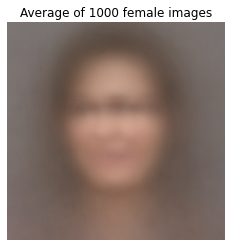

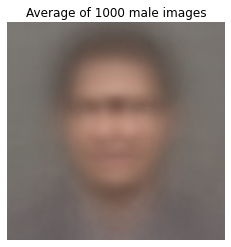

In [ ]:
# Subset by gender to find Average Male & Average Female face 
# subset for genders
df_gender0 = df['gender'] == 0
df_gender1 = df['gender'] == 1
df0 = df[df_gender0]     # gender 0 female dataframe for visualization
df1 = df[~df_gender0]    # gender 1 male dataframe for visualization
all_mean4000 = find_mean_img(df0['pixels'][:1000], '1000 female')
all_mean4000 = find_mean_img(df1['pixels'][:1000], '1000 male')

Despite being seemingly blurry, I percieve a distinct gender difference between the two composite images.

In [ ]:
# spot check the 'apply' application of the function #
df['pixels'][:5]

0    [255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...
2    [92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96....
4    [61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30....
5    [97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,...
6    [190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203...
Name: pixels, dtype: object

In [ ]:
### Are there null values in the pixel column? ###
print("There are "+ str(df.pixels.isnull().sum())+ " null values in the pixels column.")

There are 0 null values in the pixels column


#**Mentor AJ:**

"(f.1) Once images have been represented as
long vectors, and stacked up to create
the design matrix X, and labels have been
stored in vector y, so that each row of X
represents an image and the value of y at
that row represents the label of such image,
you can study pairwise correlations among
the columns of X (the feature space),
being aware of the fact that the number
of columns of X might be large."

##**Prem:** 

Since the values in the pixels column are very long vectors of 150,000 numbers, I'm not sure how to proceed with a comparison. Can you please help steer me in the right direction?

In [ ]:
# create a dataframe from the arrays of pixel values and the target label (age) column
df_pixels = df['pixels']
df_age = df['age']

frame = {'pixels':df_pixels, 'age':df_age}
result = pd.DataFrame(frame)
result.head()

,pixels,age
0,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",28
2,"[92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96....",60
4,"[61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30....",41
5,"[97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,...",52
6,"[190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203...",34


In [ ]:
# Pearson correlation coefficient among the columns
# df.pixel is not considered (each value is a vector of 150,000 numbers)
df.corr(method ='pearson')

,photo_taken,gender,face_score,date_of_birth,age
photo_taken,1.000000,-0.013188,0.044048,0.764839,0.041045
gender,-0.013188,1.000000,-0.149291,-0.105283,0.147103
face_score,0.044048,-0.149291,1.000000,0.115962,-0.125792
date_of_birth,0.764839,-0.105283,0.115962,1.000000,-0.612285
age,0.041045,0.147103,-0.125792,-0.612285,1.000000


#**Mentor AJ:**

"Some suggestions to deal with this include:

* show correlation heat-maps for 1-2 subsets of the columns of X
* build a data structure to group the columns of X (their column indexes
in X) according to their pairwise correlation coefficients: low (less than 0.5),
mid (from 0.5 and less than 0.7), high (from 0.7 and up).

(f.2) Show histograms of subsets of columns of X, colored according to
classes (or bins of classes, as discussed before)"

##**Prem:** 

Can you please give me an example of subsets to compare? 


#**Mentor AJ:** 

"(f.3) See if it is possible to select a fixed region for all images were certain
features are located (choose one)--for instance: eyes, forehead, nose, and
study statistical differences among these regions with respect to (for instance,
age groups, and gender groups). Note that these regions would be identified
in the images themselves (not matrix X--although there is a connection between
the two)

(f.4) Is there something that can be said about the skin color associated with
the dataset of images, and the relationship of this information and other variables
such as age and gender? Note: this connected with "Bias and Fairness in Machine
Learning". See this, for instance: https://arxiv.org/pdf/1908.09635.pdf.
Again, this analysis would be conducted on the images themselves

(g) The main output of this phase (Wrangling + EDA), in addition to the analysis
in the notebook itself, are the matrix X and vector y."

## **Prem:**

(f.3) One possible approach I could take: For a subset of the data, crop new rectangular images from the eye area of the image and compare the underlying pixel data statistically. This would be an interesting challenge, but I'm wondering what statistics I could compare the images on? Similarity? Can you guide me on this one?

(f.4) Interesting issue. Thank you for raising it! In my research, I came across a [UTKFace dataset](https://https://susanqq.github.io/UTKFace/) that has a 'race' label where: "[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern)." Interestingly, "The ground truth of age, gender and race are estimated through the DEX algorithm and double checked by a human annotator." This is a whole other can of worms beyond the scope of this project I believe. 

I can say upon visual inspection (non-exhaustive) of the image dataset we are using on this problem, I've noticed that "White" faces seem to be overrepresented compared to non-white faces.

# **VIII. REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles


---


@article{Rothe-IJCV-2018,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision},
  volume={126},
  number={2-4},
  pages={144--157},
  year={2018},
  publisher={Springer}
}

@InProceedings{Rothe-ICCVW-2015,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {DEX: Deep EXpectation of apparent age from a single image},
  booktitle = {IEEE International Conference on Computer Vision Workshops (ICCVW)},
  year = {2015},
  month = {December},
}